In [1]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D , MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Activation, Add
from tensorflow.keras.layers import ZeroPadding2D, Input, AveragePooling2D, Flatten, Dense, Dropout, concatenate
from matplotlib import pyplot as plt
import tensorflow as ts

##################
# IMPORTS
##################

import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils

In [2]:
img_width=64; img_height=64
IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/"
TRAIN_CLASSES_PATH = "C:/Projects/VenusDenoise/out_tests/0100_1000-64-train7.csv"
VALID_CLASSES_PATH = "C:/Projects/VenusDenoise/out_tests/train_classes/0100_1000-64-7.csv"

batch_size=16
class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.0898
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.3248

In [3]:
train_files, train_classes, train_images = \
        dsutils.readDatasetClassification(IMG_PATH, img_width, img_height, radiance_limits, TRAIN_CLASSES_PATH)



Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/
Noisy files:8738
Nitid files:8738


In [4]:
val_files, val_classes, val_images = \
    dsutils.readDatasetClassification(IMG_PATH + "validation/", img_width, img_height, radiance_limits, VALID_CLASSES_PATH)


Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/validation/
Noisy files:2208
Nitid files:2208


In [5]:
train_images = np.reshape(train_images, (len(train_images), img_height, img_width, 1))  
val_images= np.reshape(val_images, (len(val_images), img_height, img_width, 1))  

#train_classes = train_classes.squeeze()
#valid_classes = valid_classes.squeeze()

train_classes= np.reshape(train_classes, (len(train_classes), 1))  
val_classes= np.reshape(val_classes, (len(val_classes), 1))  

In [6]:
train_classes = tf.keras.utils.to_categorical( train_classes, num_classes=None, dtype='float32')
val_classes = tf.keras.utils.to_categorical( val_classes, num_classes=None, dtype='float32')

In [7]:
train_classes.shape


(8738, 4)

In [8]:
start_neurons = 16

input_layer = Input((img_width, img_height,1))

conv1 = Conv2D(start_neurons*1,(3,3), activation='relu', padding='same')(input_layer)
conv1 = Conv2D(start_neurons*1,(3,3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2,2))(conv1)
pool1 = Dropout(0.25)(pool1)

conv2 = Conv2D(start_neurons*2,(3,3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(start_neurons*2,(3,3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2,2))(conv2)
pool2 = Dropout(0.25)(pool2)

conv3 = Conv2D(start_neurons*4,(3,3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(start_neurons*4,(3,3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D((2,2))(conv3)
pool3 = Dropout(0.25)(pool3)

conv4 = Conv2D(start_neurons*8,(3,3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(start_neurons*8,(3,3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D((2,2))(conv4)
pool4 = Dropout(0.25)(pool4)

#Middle
convm = Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(pool4)
convm = Flatten()(convm)
output_layer = Dense(4, activation='softmax')(convm)

model = Model(input_layer, output_layer)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248  

In [9]:
from tensorflow.keras.optimizers import Nadam
model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics =['accuracy'])

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5000)

In [11]:


hist = model.fit(train_images, train_classes, 
                        epochs=500,
                        batch_size=16, 
                        verbose=1, 
                        validation_data=(val_images, val_classes),
                        callbacks=[callback])


Epoch 1/500
547/547 [==============================] - 13s 16ms/step - loss: 1.0023 - accuracy: 0.5901 - val_loss: 1.5861 - val_accuracy: 0.3542
Epoch 2/500
547/547 [==============================] - 9s 16ms/step - loss: 0.9481 - accuracy: 0.6228 - val_loss: 1.7189 - val_accuracy: 0.3573
Epoch 3/500
547/547 [==============================] - 9s 16ms/step - loss: 0.9330 - accuracy: 0.6282 - val_loss: 1.6263 - val_accuracy: 0.3510
Epoch 4/500
547/547 [==============================] - 9s 16ms/step - loss: 0.9336 - accuracy: 0.6206 - val_loss: 1.9172 - val_accuracy: 0.3569
Epoch 5/500
547/547 [==============================] - 9s 16ms/step - loss: 0.9231 - accuracy: 0.6268 - val_loss: 1.7014 - val_accuracy: 0.3487
Epoch 6/500
547/547 [==============================] - 9s 16ms/step - loss: 0.9197 - accuracy: 0.6332 - val_loss: 1.6461 - val_accuracy: 0.3492
Epoch 7/500
547/547 [==============================] - 9s 16ms/step - loss: 0.9129 - accuracy: 0.6316 - val_loss: 1.8189 - val_accuracy

547/547 [==============================] - 9s 16ms/step - loss: 0.7901 - accuracy: 0.6823 - val_loss: 1.6935 - val_accuracy: 0.3465
Epoch 58/500
547/547 [==============================] - 9s 16ms/step - loss: 0.7928 - accuracy: 0.6789 - val_loss: 1.7664 - val_accuracy: 0.3401
Epoch 59/500
547/547 [==============================] - 9s 16ms/step - loss: 0.7855 - accuracy: 0.6823 - val_loss: 1.7090 - val_accuracy: 0.3388
Epoch 60/500
547/547 [==============================] - 9s 16ms/step - loss: 0.7820 - accuracy: 0.6835 - val_loss: 1.7440 - val_accuracy: 0.3492
Epoch 61/500
547/547 [==============================] - 9s 16ms/step - loss: 0.7755 - accuracy: 0.6851 - val_loss: 1.7706 - val_accuracy: 0.3478
Epoch 62/500
547/547 [==============================] - 9s 16ms/step - loss: 0.7776 - accuracy: 0.6883 - val_loss: 1.7283 - val_accuracy: 0.3401
Epoch 63/500
547/547 [==============================] - 9s 16ms/step - loss: 0.7736 - accuracy: 0.6893 - val_loss: 1.7724 - val_accuracy: 0.342

547/547 [==============================] - 9s 16ms/step - loss: 0.6400 - accuracy: 0.7503 - val_loss: 2.1569 - val_accuracy: 0.3447
Epoch 114/500
547/547 [==============================] - 9s 16ms/step - loss: 0.6410 - accuracy: 0.7485 - val_loss: 2.2600 - val_accuracy: 0.3279
Epoch 115/500
547/547 [==============================] - 9s 16ms/step - loss: 0.6456 - accuracy: 0.7474 - val_loss: 2.1010 - val_accuracy: 0.3184
Epoch 116/500
547/547 [==============================] - 9s 16ms/step - loss: 0.6487 - accuracy: 0.7490 - val_loss: 2.1381 - val_accuracy: 0.3460
Epoch 117/500
547/547 [==============================] - 9s 16ms/step - loss: 0.6560 - accuracy: 0.7440 - val_loss: 2.0656 - val_accuracy: 0.3397
Epoch 118/500
547/547 [==============================] - 9s 16ms/step - loss: 0.6423 - accuracy: 0.7498 - val_loss: 2.1357 - val_accuracy: 0.3238
Epoch 119/500
547/547 [==============================] - 9s 16ms/step - loss: 0.6493 - accuracy: 0.7465 - val_loss: 1.9986 - val_accuracy:

547/547 [==============================] - 9s 16ms/step - loss: 0.5831 - accuracy: 0.7806 - val_loss: 2.2329 - val_accuracy: 0.3379
Epoch 170/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5973 - accuracy: 0.7745 - val_loss: 2.2077 - val_accuracy: 0.3342
Epoch 171/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5809 - accuracy: 0.7782 - val_loss: 2.2001 - val_accuracy: 0.3379
Epoch 172/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5835 - accuracy: 0.7787 - val_loss: 2.3626 - val_accuracy: 0.3356
Epoch 173/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5820 - accuracy: 0.7781 - val_loss: 2.4492 - val_accuracy: 0.3229
Epoch 174/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5863 - accuracy: 0.7760 - val_loss: 2.2692 - val_accuracy: 0.3447
Epoch 175/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5757 - accuracy: 0.7853 - val_loss: 2.2162 - val_accuracy:

547/547 [==============================] - 9s 16ms/step - loss: 0.5560 - accuracy: 0.7897 - val_loss: 2.2906 - val_accuracy: 0.3261
Epoch 226/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5350 - accuracy: 0.8001 - val_loss: 2.6550 - val_accuracy: 0.3252
Epoch 227/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5595 - accuracy: 0.7908 - val_loss: 2.7197 - val_accuracy: 0.3288
Epoch 228/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5679 - accuracy: 0.7897 - val_loss: 2.4487 - val_accuracy: 0.3261
Epoch 229/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5623 - accuracy: 0.7942 - val_loss: 2.4002 - val_accuracy: 0.3356
Epoch 230/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5697 - accuracy: 0.7813 - val_loss: 2.3559 - val_accuracy: 0.3342
Epoch 231/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5466 - accuracy: 0.7946 - val_loss: 2.7981 - val_accuracy:

547/547 [==============================] - 9s 16ms/step - loss: 0.5442 - accuracy: 0.7959 - val_loss: 2.5335 - val_accuracy: 0.3179
Epoch 282/500
547/547 [==============================] - 9s 16ms/step - loss: 0.6710 - accuracy: 0.7517 - val_loss: 2.4114 - val_accuracy: 0.3347
Epoch 283/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5299 - accuracy: 0.8042 - val_loss: 2.5874 - val_accuracy: 0.3302
Epoch 284/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5689 - accuracy: 0.7933 - val_loss: 2.4626 - val_accuracy: 0.3270
Epoch 285/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5151 - accuracy: 0.8033 - val_loss: 2.6427 - val_accuracy: 0.3320
Epoch 286/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5388 - accuracy: 0.8014 - val_loss: 2.2172 - val_accuracy: 0.3383
Epoch 287/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5402 - accuracy: 0.8006 - val_loss: 2.4576 - val_accuracy:

547/547 [==============================] - 9s 16ms/step - loss: 0.5678 - accuracy: 0.7883 - val_loss: 2.6926 - val_accuracy: 0.3234
Epoch 338/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5165 - accuracy: 0.8075 - val_loss: 2.5170 - val_accuracy: 0.3225
Epoch 339/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5119 - accuracy: 0.8061 - val_loss: 2.6173 - val_accuracy: 0.3315
Epoch 340/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5308 - accuracy: 0.8024 - val_loss: 2.5964 - val_accuracy: 0.3148
Epoch 341/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5334 - accuracy: 0.8029 - val_loss: 2.4743 - val_accuracy: 0.3410
Epoch 342/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5026 - accuracy: 0.8113 - val_loss: 2.6715 - val_accuracy: 0.3315
Epoch 343/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5353 - accuracy: 0.8033 - val_loss: 2.6717 - val_accuracy:

547/547 [==============================] - 9s 16ms/step - loss: 0.5266 - accuracy: 0.8088 - val_loss: 2.7875 - val_accuracy: 0.3302
Epoch 394/500
547/547 [==============================] - 9s 16ms/step - loss: 0.7564 - accuracy: 0.7707 - val_loss: 2.2630 - val_accuracy: 0.3306
Epoch 395/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5950 - accuracy: 0.7874 - val_loss: 2.5487 - val_accuracy: 0.3456
Epoch 396/500
547/547 [==============================] - 9s 16ms/step - loss: 0.6965 - accuracy: 0.7470 - val_loss: 1.7418 - val_accuracy: 0.3397
Epoch 397/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5805 - accuracy: 0.7819 - val_loss: 2.3366 - val_accuracy: 0.3401
Epoch 398/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5361 - accuracy: 0.7986 - val_loss: 2.4807 - val_accuracy: 0.3252
Epoch 399/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5016 - accuracy: 0.8111 - val_loss: 2.7136 - val_accuracy:

547/547 [==============================] - 9s 16ms/step - loss: 0.5139 - accuracy: 0.8089 - val_loss: 2.5748 - val_accuracy: 0.3478
Epoch 450/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5019 - accuracy: 0.8145 - val_loss: 3.1245 - val_accuracy: 0.3379
Epoch 451/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5091 - accuracy: 0.8108 - val_loss: 2.6763 - val_accuracy: 0.3261
Epoch 452/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5018 - accuracy: 0.8114 - val_loss: 2.9710 - val_accuracy: 0.3324
Epoch 453/500
547/547 [==============================] - 9s 16ms/step - loss: 0.6326 - accuracy: 0.7719 - val_loss: 1.8778 - val_accuracy: 0.3324
Epoch 454/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5557 - accuracy: 0.7933 - val_loss: 2.4610 - val_accuracy: 0.3401
Epoch 455/500
547/547 [==============================] - 9s 16ms/step - loss: 0.5146 - accuracy: 0.8073 - val_loss: 2.6403 - val_accuracy:

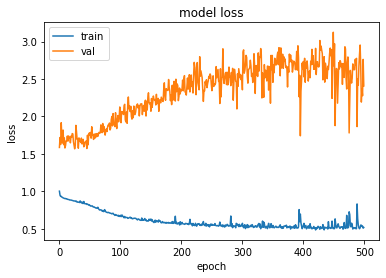

In [12]:
##################
# REPORTS
##################
import ReportsK as reports
reports.plotHistory( hist )

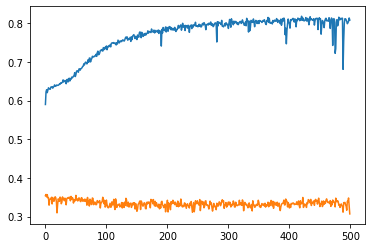

In [13]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])